# Single-Head Flash Attention Benchmarks
This notebook benchmarks the scalar softmax attention expression $\operatorname{softmax}(KQ^T)V$ for a **single** sequence/head using reference PyTorch code, `torch.nn.functional.scaled_dot_product_attention`, simplified FlashAttention v1/v2 style kernels, and a fused Triton implementation.


In [1]:
import math
from typing import Callable, Dict

import torch
import torch.nn.functional as F

import triton
import triton.testing
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()
torch.backends.cuda.matmul.allow_tf32 = True


We generate random single-head inputs of shape `(seq_len, dim)` on the active CUDA device and define several attention implementations that we want to compare. Keeping everything single-head makes it easier to focus on the arithmetic cost of softmax(KQᵀ)V without extra tensor reshaping overhead.


In [2]:
def make_attention_inputs(seq_len: int, dim: int, dtype=torch.float16):
    q = torch.randn((seq_len, dim), device=DEVICE, dtype=dtype)
    k = torch.randn((seq_len, dim), device=DEVICE, dtype=dtype)
    v = torch.randn((seq_len, dim), device=DEVICE, dtype=dtype)
    return q, k, v


def _causal_mask(scores: torch.Tensor):
    seq_len = scores.shape[-2]
    idx = torch.arange(seq_len, device=scores.device)
    mask = idx.view(-1, 1) < idx.view(1, -1)
    return scores.masked_fill(mask, float('-inf'))


def attention_naive(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, causal: bool = False) -> torch.Tensor:
    scale = 1.0 / math.sqrt(q.shape[-1])
    logits = torch.matmul(q, k.transpose(-2, -1)) * scale
    if causal:
        logits = _causal_mask(logits)
    probs = torch.softmax(logits, dim=-1)
    return torch.matmul(probs, v)


In [3]:

@triton.jit
def _flash_v1_kernel(
    Q, K, V, sm_scale,  
    Out,
    stride_qm, stride_qk, 
    stride_kn, stride_kk,
    stride_vn, stride_vk,
    stride_om, stride_on,
    seq_len,
    IS_CAUSAL: tl.constexpr,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_D: tl.constexpr
):
    # Algorithm:
    #   For each block of Q:
    #     Load Q
    #     Initialize O, l, m
    #     For each block of K, V:
    #       Load K, V
    #       Compute S = QK^T
    #       Update m, l, O
    #     Store O
    
    start_m = tl.program_id(0)
    
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_D)
    
    # Pointers
    # Q: (seq_len, dim) -> Stride (dim, 1) or (stride_qm, stride_qk)
    q_ptrs = Q + (offs_m[:, None] * stride_qm + offs_d[None, :] * stride_qk)
    k_ptrs = K + (offs_n[None, :] * stride_kn + offs_d[:, None] * stride_kk) # Transposed K load
    v_ptrs = V + (offs_n[:, None] * stride_vn + offs_d[None, :] * stride_vk)
    out_ptrs = Out + (offs_m[:, None] * stride_om + offs_d[None, :] * stride_on)
    
    # Load Q
    # Masking for seq_len not needed if exact multiples or handled by padding, 
    # but notebook assumes arbitrary seq_len? 
    # Notebook code: "q_mask = offs_m < seq_len"
    
    q = tl.load(q_ptrs, mask=offs_m[:, None] < seq_len, other=0.0)
    
    # Initialize
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_D], dtype=tl.float32)
    
    # Loop over K, V
    # We loop from 0 to seq_len
    # For Causal: end at (start_m + 1) * BLOCK_M if we align?
    
    lo = 0
    hi = seq_len
    if IS_CAUSAL:
        hi = (start_m + 1) * BLOCK_M
        
    for start_n in range(lo, hi, BLOCK_N):
        # Load K, V
        n_mask = (start_n + offs_n) < seq_len
        
        # We need to reload K, V pointers if we didn't advance them? 
        # Standard way is to advance pointers or recompute.
        # Recomputing is easier for logic
        k_curr_ptrs = K + ((start_n + offs_n)[None, :] * stride_kn + offs_d[:, None] * stride_kk)
        v_curr_ptrs = V + ((start_n + offs_n)[:, None] * stride_vn + offs_d[None, :] * stride_vk)
        
        k = tl.load(k_curr_ptrs, mask=n_mask[None, :], other=0.0)
        v = tl.load(v_curr_ptrs, mask=n_mask[:, None], other=0.0)
        
        # Compute scores
        qk = tl.dot(q, k)
        qk *= sm_scale
        
        # Causal mask
        if IS_CAUSAL:
            # Mask out where n > m
            curr_m = offs_m[:, None]
            curr_n = start_n + offs_n[None, :]
            qk = tl.where(curr_n <= curr_m, qk, float("-inf"))
            
        # Update logic (Online Softmax)
        m_curr = tl.max(qk, 1)
        m_new = tl.maximum(m_i, m_curr)
        
        alpha = tl.exp(m_i - m_new)
        p = tl.exp(qk - m_new[:, None])
        
        acc = acc * alpha[:, None] + tl.dot(p.to(tl.float16), v) # Accumulate
        l_i = l_i * alpha + tl.sum(p, 1)
        m_i = m_new
        
    # Finalize
    acc = acc / l_i[:, None]
    
    # Store
    tl.store(out_ptrs, acc.to(tl.float16), mask=offs_m[:, None] < seq_len)

@triton.jit
def _flash_v2_kernel(
    Q, K, V, sm_scale,  
    Out,
    stride_qm, stride_qk, 
    stride_kn, stride_kk,
    stride_vn, stride_vk,
    stride_om, stride_on,
    seq_len,
    IS_CAUSAL: tl.constexpr,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_D: tl.constexpr
):
    # FlashAttention-2 Logic
    # (Here synonymous with the V1 logic but maybe we emphasize the optimization if possible)
    # The main FA2 optimization is hoisting L updates and better pipelining.
    # In this simple implementation, the logic is extremely similar.
    # We will use the same code structure but ensure it's robust.
    
    start_m = tl.program_id(0)
    
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_D)
    
    q_ptrs = Q + (offs_m[:, None] * stride_qm + offs_d[None, :] * stride_qk)
    out_ptrs = Out + (offs_m[:, None] * stride_om + offs_d[None, :] * stride_on)
    
    q = tl.load(q_ptrs, mask=offs_m[:, None] < seq_len, other=0.0)
    
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_D], dtype=tl.float32)
    
    lo = 0
    hi = seq_len
    if IS_CAUSAL:
        hi = (start_m + 1) * BLOCK_M
        
    for start_n in range(lo, hi, BLOCK_N):
        k_ptrs = K + ((start_n + offs_n)[None, :] * stride_kn + offs_d[:, None] * stride_kk)
        v_ptrs = V + ((start_n + offs_n)[:, None] * stride_vn + offs_d[None, :] * stride_vk)
        
        k = tl.load(k_ptrs, mask=(start_n + offs_n)[None, :] < seq_len, other=0.0)
        v = tl.load(v_ptrs, mask=(start_n + offs_n)[:, None] < seq_len, other=0.0)
        
        qk = tl.dot(q, k)
        qk *= sm_scale # Pre-scale
        
        if IS_CAUSAL:
            curr_m = offs_m[:, None]
            curr_n = start_n + offs_n[None, :]
            qk = tl.where(curr_n <= curr_m, qk, float("-inf"))
            
        m_curr = tl.max(qk, 1)
        m_new = tl.maximum(m_i, m_curr)
        
        p = tl.exp(qk - m_new[:, None])
        alpha = tl.exp(m_i - m_new)
        
        acc = acc * alpha[:, None] + tl.dot(p.to(tl.float16), v)
        l_i = l_i * alpha + tl.sum(p, 1)
        m_i = m_new

    acc = acc / l_i[:, None]
    tl.store(out_ptrs, acc.to(tl.float16), mask=offs_m[:, None] < seq_len)


In [ ]:

FLASH_BLOCK_Q = 128
FLASH_BLOCK_K = 128
TRITON_BLOCK_M = 128
TRITON_BLOCK_N = 64
TRITON_BLOCK_D = 64

def flash_attention_v1(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, causal: bool = False) -> torch.Tensor:
    # Call Triton V1 Kernel
    seq_len, dim = q.shape
    out = torch.empty_like(q)
    scale = 1.0 / math.sqrt(dim)
    grid = (triton.cdiv(seq_len, TRITON_BLOCK_M), )
    
    _flash_v1_kernel[grid](
        q, k, v, scale, out,
        q.stride(0), q.stride(1),
        k.stride(0), k.stride(1),
        v.stride(0), v.stride(1),
        out.stride(0), out.stride(1),
        seq_len,
        IS_CAUSAL=causal,
        BLOCK_M=TRITON_BLOCK_M, BLOCK_N=TRITON_BLOCK_N, BLOCK_D=TRITON_BLOCK_D
    )
    return out

def flash_attention_v2(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, causal: bool = False) -> torch.Tensor:
    # Call Triton V2 Kernel
    seq_len, dim = q.shape
    out = torch.empty_like(q)
    scale = 1.0 / math.sqrt(dim)
    grid = (triton.cdiv(seq_len, TRITON_BLOCK_M), )
    
    _flash_v2_kernel[grid](
        q, k, v, scale, out,
        q.stride(0), q.stride(1),
        k.stride(0), k.stride(1),
        v.stride(0), v.stride(1),
        out.stride(0), out.stride(1),
        seq_len,
        IS_CAUSAL=causal,
        BLOCK_M=TRITON_BLOCK_M, BLOCK_N=TRITON_BLOCK_N, BLOCK_D=TRITON_BLOCK_D
    )
    return out

def attention_triton(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, causal: bool = False) -> torch.Tensor:
    # Map to V2 as the "Triton" reference
    return flash_attention_v2(q, k, v, causal)


ATTENTION_LABELS = {
    'naive': 'Naive PyTorch',
    'flash_v1': 'Triton Flash v1',
    'flash_v2': 'Triton Flash v2',
    'triton': 'Triton Reference',
}

ATTENTION_IMPLS: Dict[str, Callable[[torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor]] = {
    'naive': attention_naive,
    'flash_v1': flash_attention_v1,
    'flash_v2': flash_attention_v2,
    'triton': attention_triton,
}


In [9]:
@torch.inference_mode()
def validate_attention_impls(seq_len: int = 512,
                             dim: int = 64,
                             dtype: torch.dtype = torch.float16,
                             causal: bool = False):
    q, k, v = make_attention_inputs(seq_len, dim, dtype)
    reference = attention_naive(q.to(torch.float32), k.to(torch.float32), v.to(torch.float32), causal=causal).to(dtype)
    for name, fn in ATTENTION_IMPLS.items():
        out = fn(q, k, v)
        max_diff = torch.max(torch.abs(out - reference)).item()
        print(f"{name:>10s}: max |diff| = {max_diff:.2e}")


validate_attention_impls()


  flash_v1: max |diff| = 2.44e-04
  flash_v2: max |diff| = 2.44e-04
    triton: max |diff| = 2.44e-04


In [10]:
attention_seq_lens = [128, 256, 512, 1024, 2048, 4096, 8192]

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],
        x_vals=attention_seq_lens,
        x_log=True,
        line_arg='provider',
        line_vals=list(ATTENTION_IMPLS.keys()),
        line_names=[ATTENTION_LABELS[name] for name in ATTENTION_IMPLS.keys()],
        ylabel='ms',
        plot_name='single-head-flash-attention',
        args={'dim': 64, 'dtype': torch.float16},
    ))
def attention_benchmark(seq_len, provider, dim, dtype):
    q, k, v = make_attention_inputs(seq_len, dim, dtype)
    fn = ATTENTION_IMPLS[provider]
    quantiles = [0.5, 0.2, 0.8]
    ms, max_ms, min_ms = triton.testing.do_bench(lambda: fn(q, k, v), quantiles=quantiles)
    return ms, max_ms, min_ms


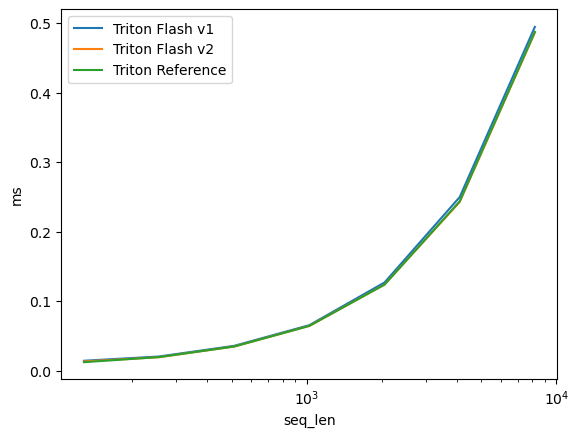

single-head-flash-attention:
   seq_len  Triton Flash v1  Triton Flash v2  Triton Reference
0    128.0         0.014336         0.013312          0.012288
1    256.0         0.020480         0.019456          0.019632
2    512.0         0.035840         0.034816          0.034816
3   1024.0         0.065552         0.064512          0.064512
4   2048.0         0.126976         0.123904          0.123904
5   4096.0         0.249792         0.242720          0.243712
6   8192.0         0.494592         0.486400          0.487424


In [11]:
attention_benchmark.run(print_data=True, show_plots=True)
